In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('linear_regression_advance').getOrCreate()

from pyspark.ml.regression import LinearRegression

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 10:30:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/23 10:30:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder.appName("DataMiningProject").getOrCreate()

#Load CSV file
file_path = "Fin.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# View data structure
df.printSchema()

# Display the first few rows of data
df.show(5)

root
 |-- Area Code (FAO): integer (nullable = true)
 |-- Area: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Agriculture_CG: double (nullable = true)
 |-- Total_Expenditure_CG: double (nullable = true)
 |-- Incidence of malnutrition: double (nullable = true)
 |-- GDP_Per_Capita_PPP: double (nullable = true)
 |-- Children_Under_5_Wasting_Percent: double (nullable = true)
 |-- GDP(mean): double (nullable = true)
 |-- Income Level: double (nullable = true)

+---------------+-------+----+--------------+--------------------+-------------------------+------------------+--------------------------------+---------+------------+
|Area Code (FAO)|   Area|Year|Agriculture_CG|Total_Expenditure_CG|Incidence of malnutrition|GDP_Per_Capita_PPP|Children_Under_5_Wasting_Percent|GDP(mean)|Income Level|
+---------------+-------+----+--------------+--------------------+-------------------------+------------------+--------------------------------+---------+------------+
|              

# Data reduction

In [10]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Feature column
feature_cols = [
     'Year',
     'Agriculture_CG',
     'Total_Expenditure_CG',
     'GDP_Per_Capita_PPP',
     'Children_Under_5_Wasting_Percent',
     'Incidence of malnutrition',
     'GDP(mean)',
     'Income Level'
]

#Create VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Convert the dataset to contain feature vectors
final_df = assembler.transform(df)

#View the converted data set structure
final_df.printSchema()

# Display the first few rows of data to confirm the conversion results
final_df.select("features").show(5, truncate=False)

root
 |-- Area Code (FAO): integer (nullable = true)
 |-- Area: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Agriculture_CG: double (nullable = true)
 |-- Total_Expenditure_CG: double (nullable = true)
 |-- Incidence of malnutrition: double (nullable = true)
 |-- GDP_Per_Capita_PPP: double (nullable = true)
 |-- Children_Under_5_Wasting_Percent: double (nullable = true)
 |-- GDP(mean): double (nullable = true)
 |-- Income Level: double (nullable = true)
 |-- features: vector (nullable = true)

+----------------------------------------------------+
|features                                            |
+----------------------------------------------------+
|[2017.0,60.28,2936.56,12771.0,1.6,4.2,13502.28,3.0] |
|[2018.0,74.81,3309.15,13317.1,1.6,4.1,13502.28,3.0] |
|[2019.0,55.54,3285.52,13653.2,1.6,4.1,13502.28,3.0] |
|[2020.0,82.56,3796.47,13253.8,1.6,4.1,13502.28,3.0] |
|[2021.0,112.75,4340.22,14516.3,1.6,4.1,13502.28,3.0]|
+--------------------------------------

In [14]:
from pyspark.ml.regression import LinearRegression

# Prepare data
data = final_df.select("features", "Incidence of malnutrition")
#Create linear regression model
lr = LinearRegression(labelCol="Incidence of malnutrition", featuresCol="features")

# Check the p-value of each variable
summary = lr_model.summary
print("P-values: ", summary.pValues)

P-values:  [0.7266313800747537, 0.20010054450710513, 0.2528914293913245, 0.0, 0.14404504336172685, 0.0, 0.0, 9.102537286143075e-07, 0.7151801108802842]


In [18]:
from pyspark.ml.regression import LinearRegression

# Prepare data
data = final_df.select("features", "Children_Under_5_Wasting_Percent")

#Create linear regression model
lr = LinearRegression(labelCol="Children_Under_5_Wasting_Percent", featuresCol="features")

# Check the p-value of each variable
summary = lr_model.summary
print("P-values: ", summary.pValues)

P-values:  [0.9501912200231539, 0.11601310832319722, 0.019949404397274106, 0.8237928918234922, 0.0, 0.22566296914238815, 0.4430069221773856, 0.8224534487458455, 0.9314836664661479]


+------------+-----+
|Income Level|count|
+------------+-----+
|         1.0|    6|
|         4.0|   58|
|         3.0|   90|
|         2.0|   96|
+------------+-----+

+------------+-----+
|Income Level|count|
+------------+-----+
|         1.0|    6|
|         4.0|    5|
|         3.0|    4|
|         2.0|    4|
+------------+-----+



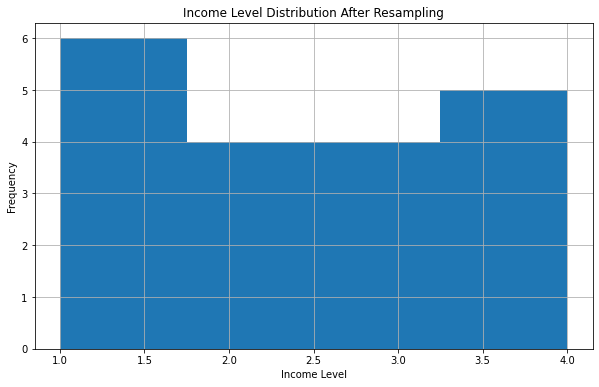

In [24]:
from pyspark.sql import SparkSession


df.groupBy("Income Level").count().show()

# Get the amount of data for each income level category
income_levels = df.select("Income Level").distinct().rdd.flatMap(lambda x: x).collect()
min_count = df.groupBy("Income Level").count().agg({"count": "min"}).collect()[0][0]

# Downsample each income level category
df_resampled = None
for level in income_levels:
     df_level = df.filter(df["Income Level"] == level)
     df_level_resampled = df_level.sample(fraction=min_count / df_level.count(), seed=123)
     if df_resampled is None:
         df_resampled = df_level_resampled
     else:
         df_resampled = df_resampled.union(df_level_resampled)

import pandas as pd
import matplotlib.pyplot as plt

pandas_df = df_resampled.toPandas()
#draw graph
plt.figure(figsize=(10, 6))
pandas_df['Income Level'].hist(bins=len(pandas_df['Income Level'].unique()))
plt.title('Income Level Distribution After Resampling')
plt.xlabel('Income Level')
plt.ylabel('Frequency')
plt.show()






# Data Projection

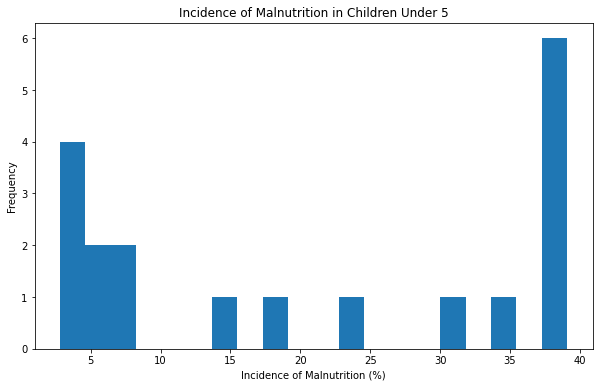

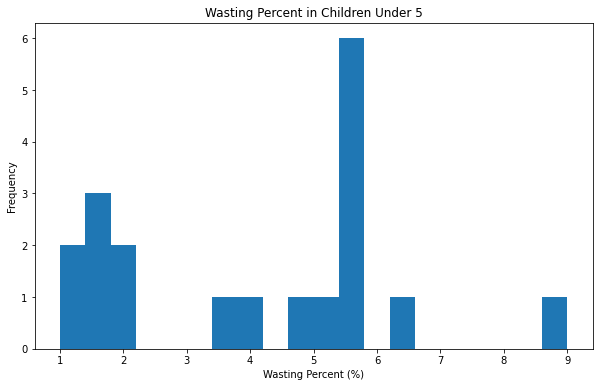

In [25]:
import matplotlib.pyplot as plt

# Plot a histogram of the prevalence of malnutrition in children under 5 years old
plt.figure(figsize=(10, 6))
pandas_df['Incidence of malnutrition'].hist(bins=20)
plt.title('Incidence of Malnutrition in Children Under 5')
plt.xlabel('Incidence of Malnutrition (%)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Plot a histogram of the percentage of wasting in children under 5 years old
plt.figure(figsize=(10, 6))
pandas_df['Children_Under_5_Wasting_Percent'].hist(bins=20)
plt.title('Wasting Percent in Children Under 5')
plt.xlabel('Wasting Percent (%)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

+-------------------------+------------------------------+
|Incidence of malnutrition|sqrt_Incidence_of_malnutrition|
+-------------------------+------------------------------+
|                      4.2|              2.04939015319192|
|                      4.1|            2.0248456731316584|
|                      4.1|            2.0248456731316584|
|                      4.1|            2.0248456731316584|
|                      4.1|            2.0248456731316584|
+-------------------------+------------------------------+
only showing top 5 rows



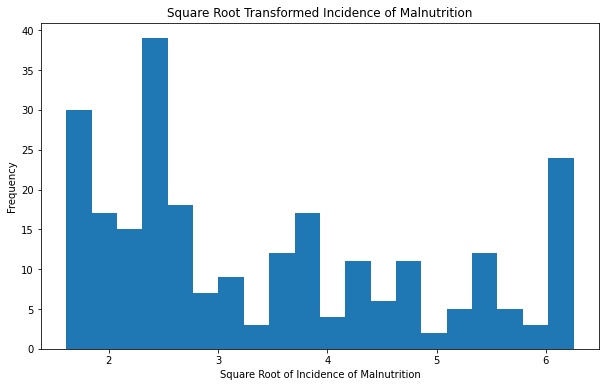

In [26]:
from pyspark.sql.functions import sqrt
import pandas as pd
import matplotlib.pyplot as plt

# Perform a square root transformation on the "Malnutrition Prevalence" column
df_transformed = df.withColumn("sqrt_Incidence_of_malnutrition", sqrt(df["Incidence of malnutrition"]))


#Convert to Pandas DataFrame
pandas_df = df_transformed.select("sqrt_Incidence_of_malnutrition").toPandas()

# Draw the square root transformed histogram
plt.figure(figsize=(10, 6))
pandas_df['sqrt_Incidence_of_malnutrition'].hist(bins=20)
plt.title('Square Root Transformed Incidence of Malnutrition')
plt.xlabel('Square Root of Incidence of Malnutrition')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

+--------------------------------+--------------------------------------+
|Children_Under_5_Wasting_Percent|log10_Children_Under_5_Wasting_Percent|
+--------------------------------+--------------------------------------+
|                             1.6|                    0.2041199826559248|
|                             1.6|                    0.2041199826559248|
|                             1.6|                    0.2041199826559248|
|                             1.6|                    0.2041199826559248|
|                             1.6|                    0.2041199826559248|
+--------------------------------+--------------------------------------+
only showing top 5 rows



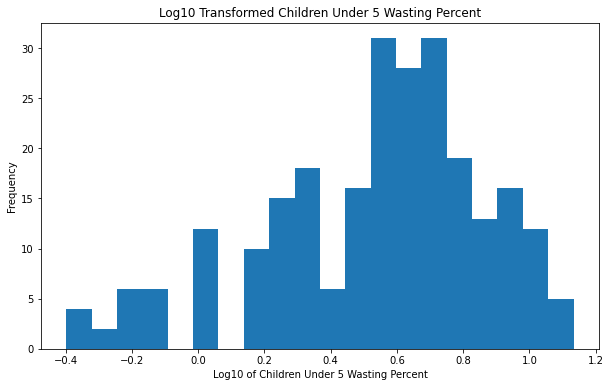

In [28]:
from pyspark.sql.functions import log10
import pandas as pd
import matplotlib.pyplot as plt

# Perform a log10 transformation on the "Under 5 wasting" column
df_transformed = df.withColumn("log10_Children_Under_5_Wasting_Percent", log10(df["Children_Under_5_Wasting_Percent"]))

#Convert to Pandas DataFrame
pandas_df = df_transformed.select("log10_Children_Under_5_Wasting_Percent").toPandas()

# Draw the log10 transformed histogram
plt.figure(figsize=(10, 6))
pandas_df['log10_Children_Under_5_Wasting_Percent'].hist(bins=20)
plt.title('Log10 Transformed Children Under 5 Wasting Percent')
plt.xlabel('Log10 of Children Under 5 Wasting Percent')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

